<a href="https://colab.research.google.com/github/pvanand07/Book-Recommendation-System/blob/master/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Re-loading the datasets
path = "/content/drive/MyDrive/Almabetter/Almabetter Projects/Book Recommender/"
ratings = pd.read_csv(path+'Ratings.csv')
users = pd.read_csv(path+'Users.csv')
books = pd.read_csv(path+'Books.csv')

# # Merging the three datasets: ratings, users, and books

# # Merging ratings with books on 'ISBN'
# ratings_books = pd.merge(ratings, books, on='ISBN', how='left')

# # Merging the above result with users on 'User-ID'
# combined_data = pd.merge(ratings_books, users, on='User-ID', how='left')

# # Display the first few rows of the merged dataframe
# display(combined_data)

<ipython-input-1-df7e3a96c98c>:14: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(path+'Books.csv')


Ratings DF

In [4]:
print(ratings.shape)
print(users.shape)
print(books.shape)

(1149780, 3)
(278858, 3)
(271360, 8)


In [6]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [9]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [10]:
print(ratings.isna().sum())
print(users.isna().sum())
print(books.isna().sum())

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
User-ID          0
Location         0
Age         110762
dtype: int64
ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


We can see that there are no missing values in the age column in the users dataset, and a few in books df. We can drop the missing values in the books dataset and merge all the three datasets.

In [15]:
combined_data = pd.merge(pd.merge(ratings, books.dropna(axis=0), on='ISBN', how='left'), users, on='User-ID', how='left')
# Basic info about the combined dataset
print('Combined Data Info:')
combined_data.info()

Combined Data Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   User-ID              1149780 non-null  int64  
 1   ISBN                 1149780 non-null  object 
 2   Book-Rating          1149780 non-null  int64  
 3   Book-Title           1031129 non-null  object 
 4   Book-Author          1031129 non-null  object 
 5   Year-Of-Publication  1031129 non-null  object 
 6   Publisher            1031129 non-null  object 
 7   Image-URL-S          1031129 non-null  object 
 8   Image-URL-M          1031129 non-null  object 
 9   Image-URL-L          1031129 non-null  object 
 10  Location             1149780 non-null  object 
 11  Age                  840288 non-null   float64
dtypes: float64(1), int64(2), object(9)
memory usage: 114.0+ MB


<Axes: >

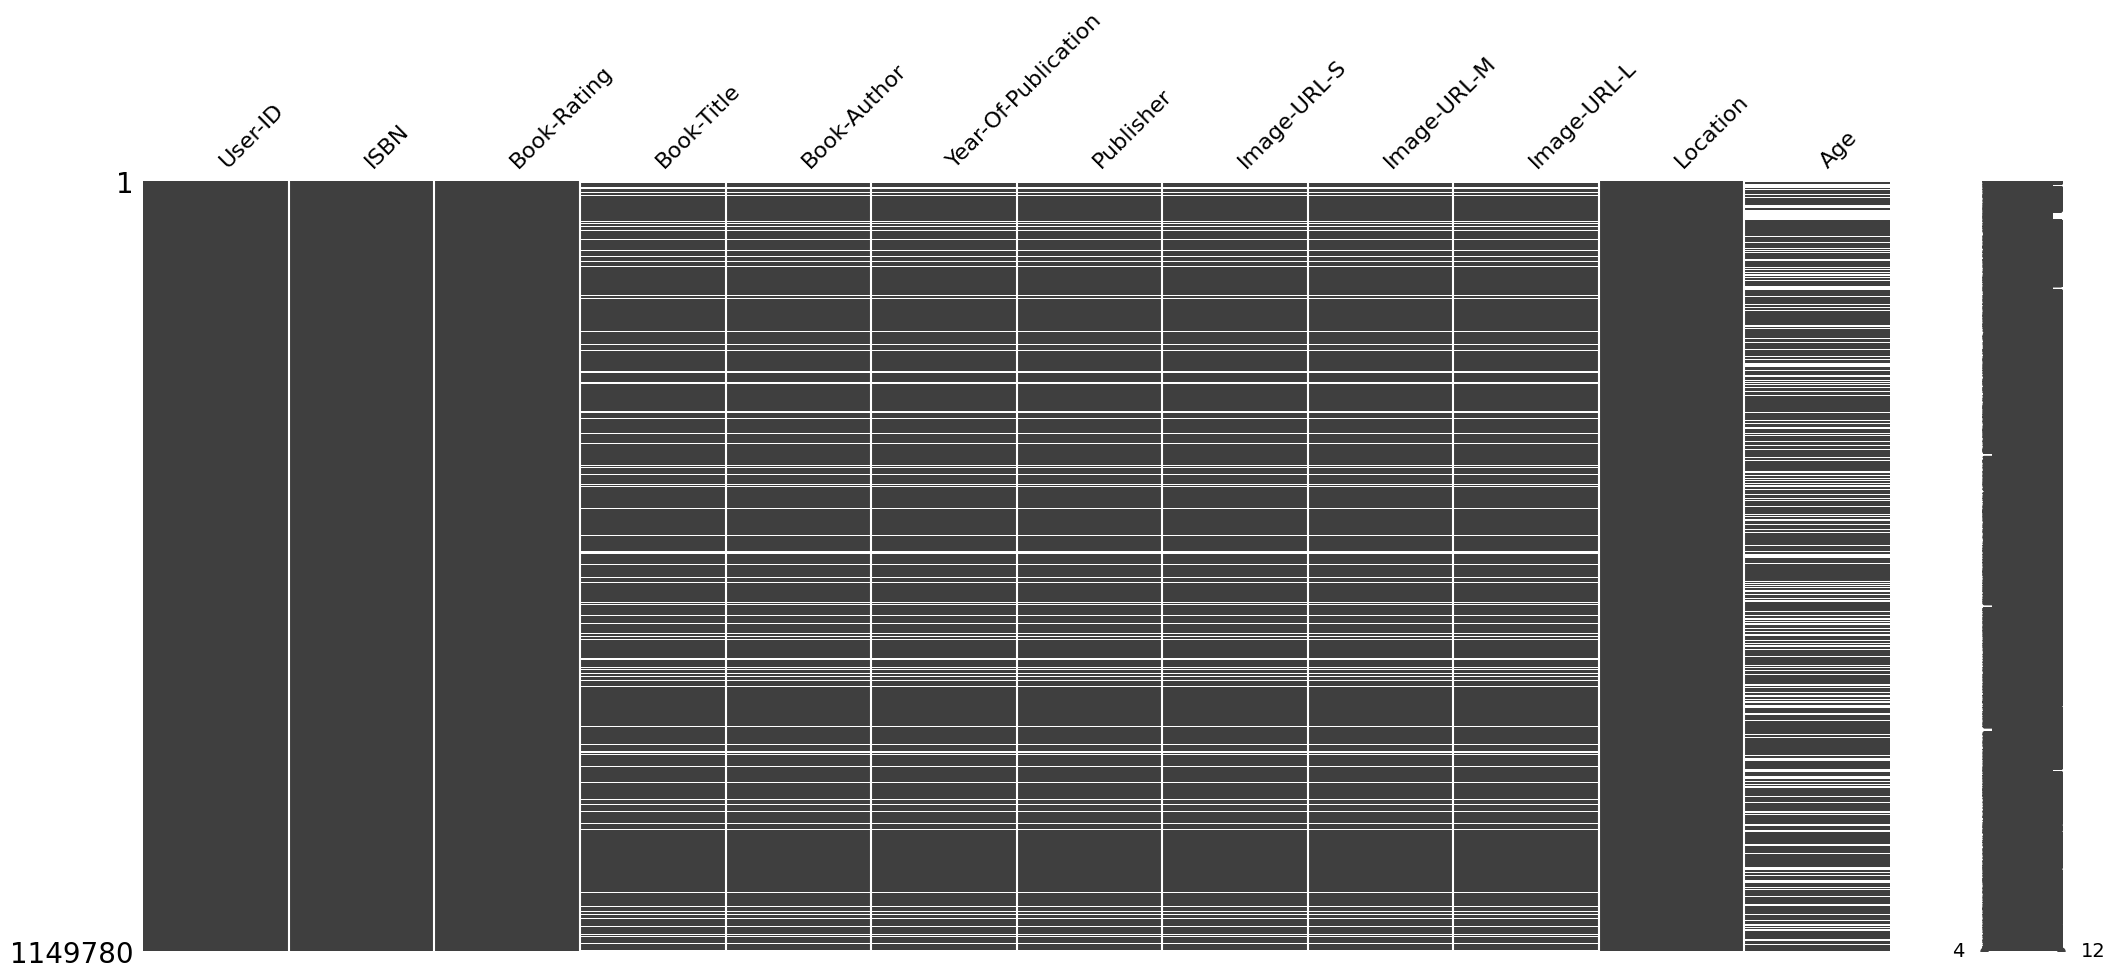

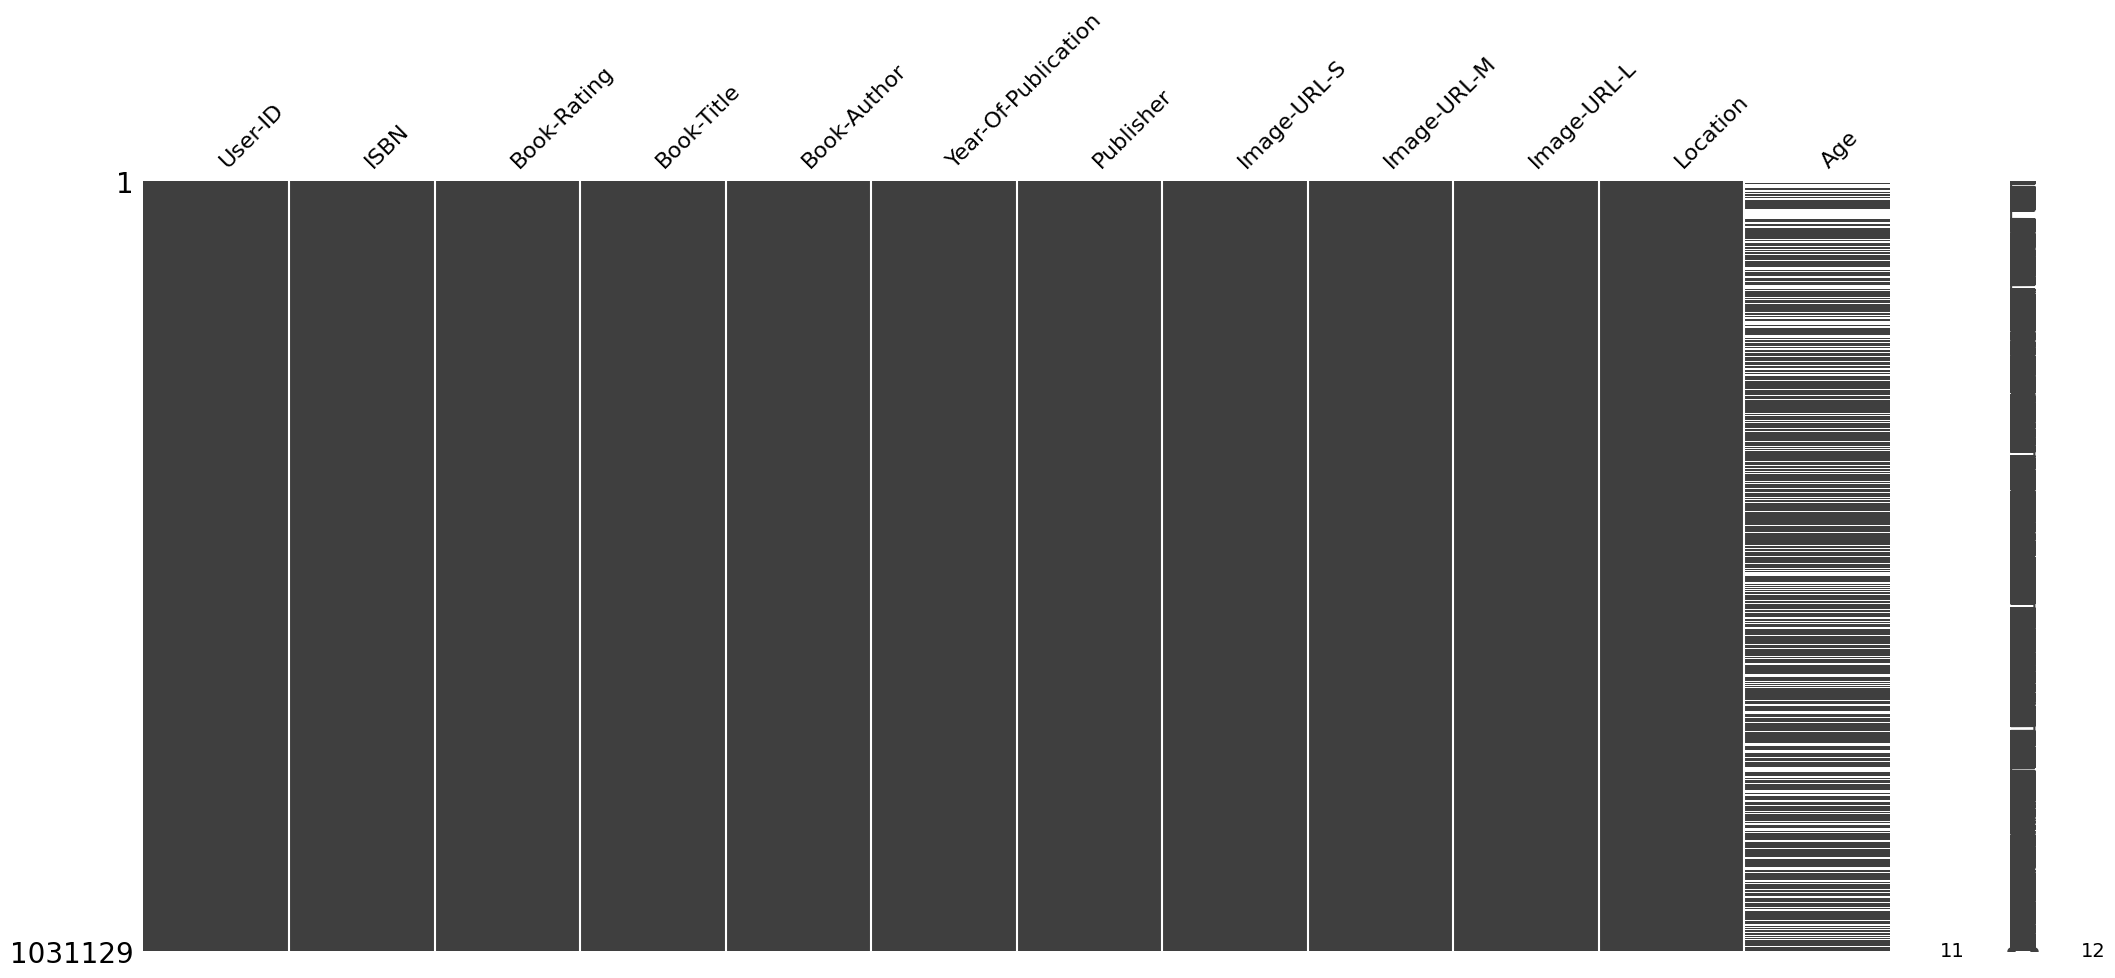

In [16]:
## Cleaning Data for EDA and visualization

# 1. Check for missing values

import missingno as msno
%matplotlib inline
msno.matrix(combined_data)

# Drop missing values in Book Title
combined_data = combined_data[combined_data['Book-Title'].notna()]
msno.matrix(combined_data)

In [ ]:
combined_data.shape

(1031136, 12)

In [17]:
combined_data['Age'].isna().sum()/len(combined_data)*100

26.944543311263676

## 2. Imputing missing values

we can see that 26.9% of the Age values are missing.

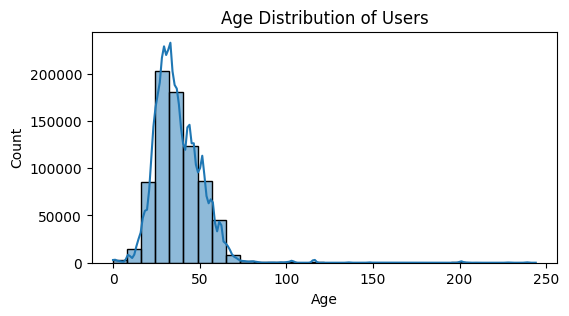

In [18]:
# Age distribution of users
plt.figure(figsize=(6, 3))
sns.histplot(combined_data['Age'], bins=30, kde=True)
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

since age distribution is right skewed, we can impute the missing values with the median age.

In [19]:
# Imputing missing values with the median age
median_age = combined_data['Age'].median()
combined_data['Age'].fillna(median_age, inplace=True)

In [20]:
combined_data.isna().sum()

User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
Location               0
Age                    0
dtype: int64

We have succesfully cleaned the data of missing values. Lets now drop duplicate values(if any)

In [30]:
combined_data.drop_duplicates(inplace=True)

Fixing datatypes for age of user and year of publication

In [31]:
## Cleaning Data for EDA and visualization

data = combined_data.copy()
# 1. Converting DataTypes
data['Year-Of-Publication'] = combined_data['Year-Of-Publication'].astype('int')
data['Age'] = combined_data['Age'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031129 entries, 0 to 1149778
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   User-ID              1031129 non-null  int64 
 1   ISBN                 1031129 non-null  object
 2   Book-Rating          1031129 non-null  int64 
 3   Book-Title           1031129 non-null  object
 4   Book-Author          1031129 non-null  object
 5   Year-Of-Publication  1031129 non-null  int64 
 6   Publisher            1031129 non-null  object
 7   Image-URL-S          1031129 non-null  object
 8   Image-URL-M          1031129 non-null  object
 9   Image-URL-L          1031129 non-null  object
 10  Location             1031129 non-null  object
 11  Age                  1031129 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 102.3+ MB


In [22]:
display(combined_data)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",35.0
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,"seattle, washington, usa",35.0
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,"h, new south wales, australia",16.0
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,"rijeka, n/a, croatia",16.0
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,"rijeka, n/a, croatia",16.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1149774,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig,http://images.amazon.com/images/P/0876044011.0...,http://images.amazon.com/images/P/0876044011.0...,http://images.amazon.com/images/P/0876044011.0...,"cedar park, texas, usa",35.0
1149775,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...,"cedar park, texas, usa",35.0
1149776,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...,"quebec, quebec, canada",18.0
1149777,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...,"mannington, west virginia, usa",38.0


# Exploratory Data Analysis (EDA) and Data Visualization

In [ ]:
(data['Age']>10) & (data['Age']<100)

0          True
1          True
2          True
3          True
4          True
           ... 
1149774    True
1149775    True
1149776    True
1149777    True
1149778    True
Name: Age, Length: 1031129, dtype: bool

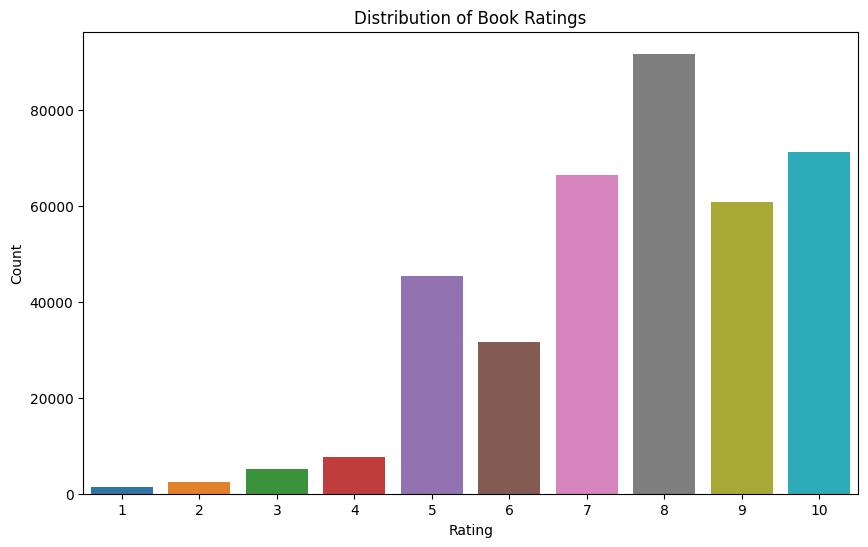

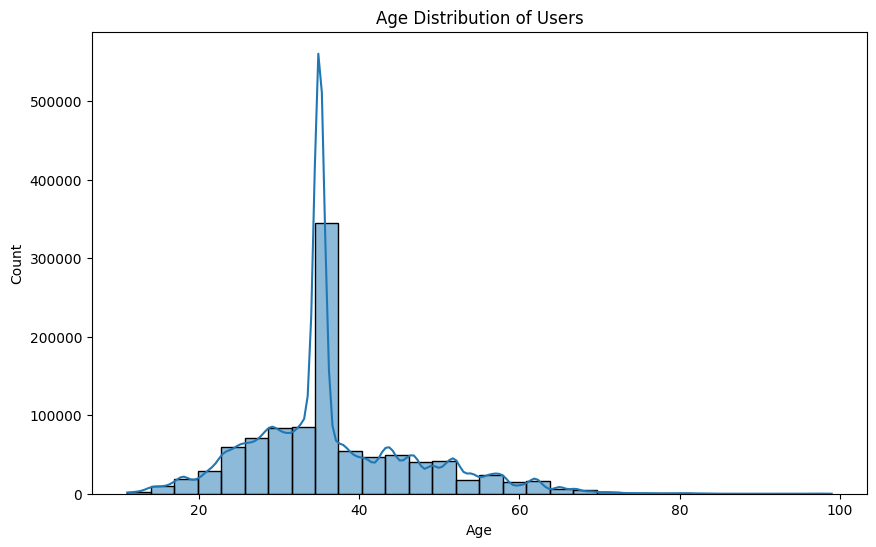

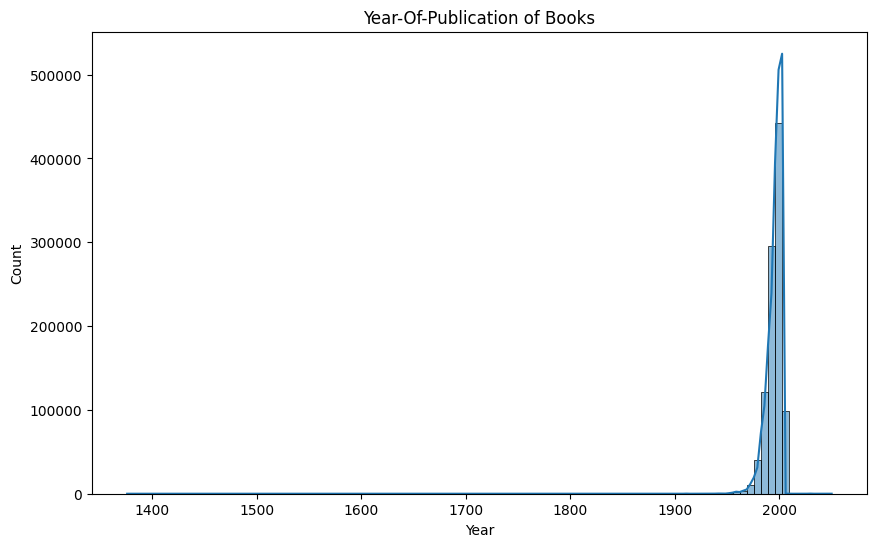

In [ ]:

# Distribution of book ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='Book-Rating', data=data[data['Book-Rating'] != 0])
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Age distribution of users
plt.figure(figsize=(10, 6))
sns.histplot(data['Age'][(data['Age']>10) & (data['Age']<100)], bins=30, kde=True)
plt.title('Age Distribution of Users')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Distribution of Year of publication
plt.figure(figsize=(10, 6))
sns.histplot(data['Year-Of-Publication'][data['Year-Of-Publication']>0], bins=100, kde=True)
plt.title('Year-Of-Publication of Books')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

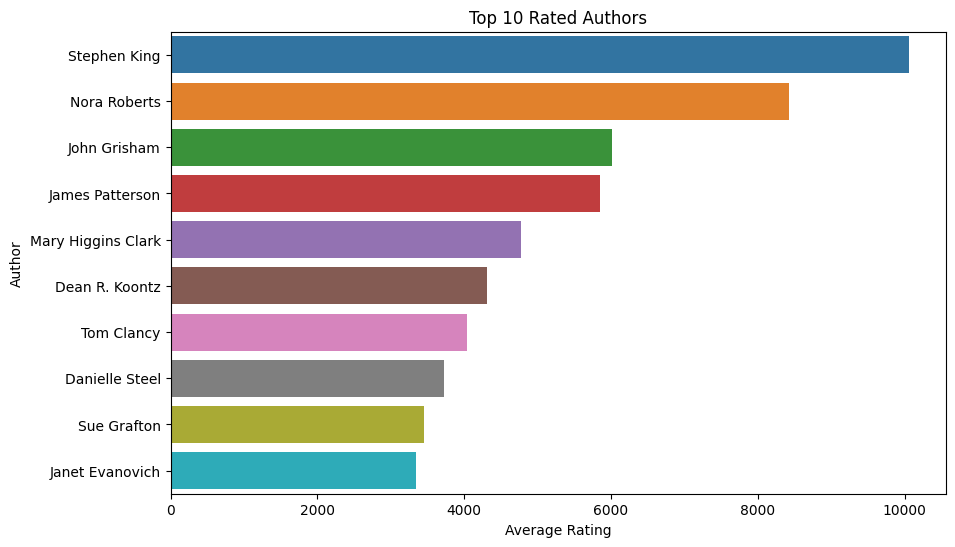

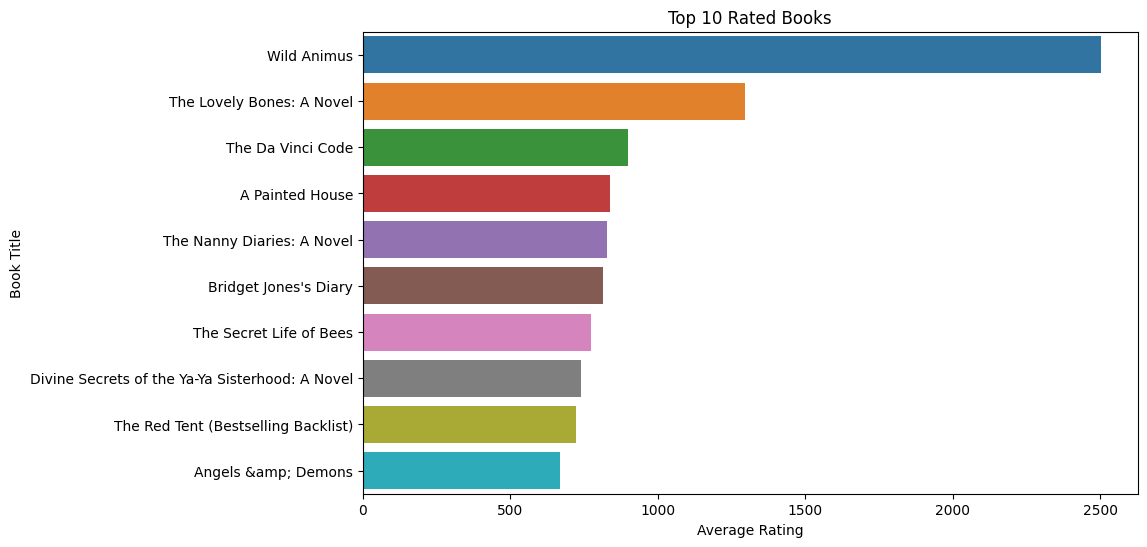

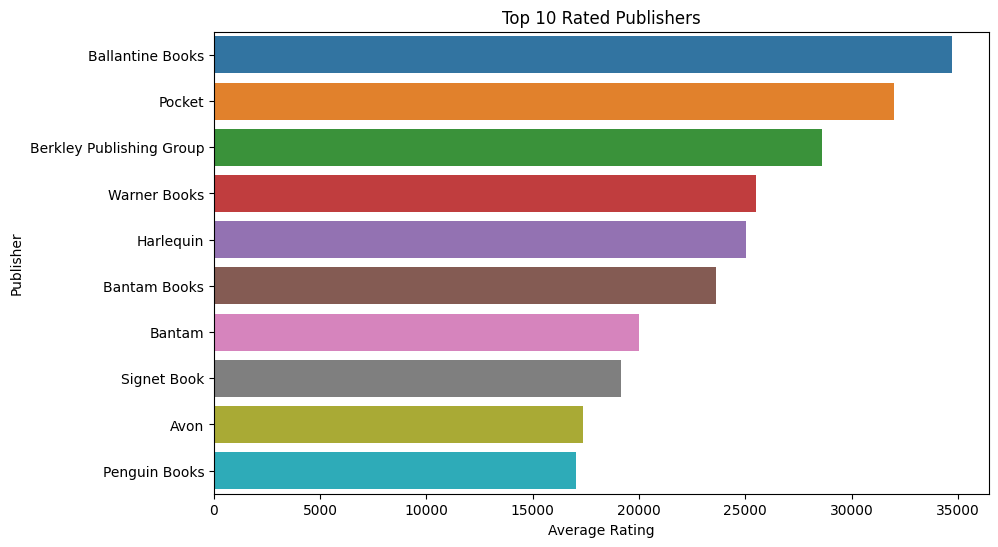

In [ ]:
# Top 10 Rated Authors, Books, and Publishers

# Top 10 Rated Authors
top_authors = combined_data.groupby('Book-Author')['Book-Rating'].count().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors.values, y=top_authors.index)
plt.title('Top 10 Rated Authors')
plt.xlabel('Average Rating')
plt.ylabel('Author')
plt.show()

# Top 10 Rated Books
top_books = combined_data.groupby('Book-Title')['Book-Rating'].count().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_books.values, y=top_books.index)
plt.title('Top 10 Rated Books')
plt.xlabel('Average Rating')
plt.ylabel('Book Title')
plt.show()

# Top 10 Rated Publishers
top_publishers = combined_data.groupby('Publisher')['Book-Rating'].count().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_publishers.values, y=top_publishers.index)
plt.title('Top 10 Rated Publishers')
plt.xlabel('Average Rating')
plt.ylabel('Publisher')
plt.show()

# Method 1: RECOMMENDATION BASED ON POPULARITY

In [23]:
combined_data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,"tyler, texas, usa",35.0
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,"seattle, washington, usa",35.0
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,"h, new south wales, australia",16.0
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,"rijeka, n/a, croatia",16.0
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,"rijeka, n/a, croatia",16.0


Lets find out the most popular books based on number of ratings and average rating. But first lets filter out books with less than 300 ratings and users with less than 30 ratings.(picked using random trials)

In [81]:
grouped_book_data = combined_data.groupby('ISBN')['Book-Rating'].count().reset_index()
selected_books = grouped_book_data[grouped_book_data['Book-Rating']>=300]['ISBN']

In [82]:
grouped_user_data = combined_data.groupby('User-ID')['Book-Rating'].count().reset_index()
selected_users = grouped_user_data[grouped_user_data['Book-Rating']>=30]['User-ID']

In [84]:
filtered_data = combined_data[combined_data['ISBN'].isin(selected_books) & combined_data['User-ID'].isin(selected_users)]
rec_popular = pd.DataFrame()
rec_popular['Mean-Book-Rating'] = filtered_data.groupby('ISBN')['Book-Rating'].mean().sort_values(ascending=False)
rec_popular['Count-Book-Rating'] = filtered_data.groupby('ISBN')['Book-Rating'].count()
rec_popular.merge(books[['ISBN', 'Book-Title']], on='ISBN', how='left')

,ISBN,Mean-Book-Rating,Count-Book-Rating,Book-Title
0,043935806X,5.557447,235,Harry Potter and the Order of the Phoenix (Boo...
1,0446310786,4.357724,246,To Kill a Mockingbird
2,059035342X,4.278261,345,Harry Potter and the Sorcerer's Stone (Harry P...
3,0439064872,4.238532,218,Harry Potter and the Chamber of Secrets (Book 2)
4,0316769487,4.042654,211,The Catcher in the Rye
...,...,...,...,...
76,0345443284,1.763889,216,While I Was Gone
77,0385720106,1.756219,201,A Map of the World
78,0440222656,1.669091,275,The Horse Whisperer
79,006101351X,1.662651,249,The Perfect Storm : A True Story of Men Agains...


# Method 2: RECOMMENDATION BASED ON COLLABORATIVE FILTERING

First lets filter out users that have provided less than 5 ratings, since collaborative filtering models requires some data to provide recommendations

In [ ]:
# Exclude users with less than 20 ratings
# Exclude books with less than 20 ratings
filtered_data_book = combined_data[combined_data.groupby('ISBN')['ISBN'].transform('size')>20]
filtered_data_user = filtered_data_book[filtered_data_book.groupby('User-ID')['User-ID'].transform('size')>20]


print("Initial Dataset Size:", combined_data.shape, "\n", "Filtered Dataset Size:", filtered_data_user.shape)

Initial Dataset Size: (1031129, 12) 
 Filtered Dataset Size: (239964, 12)


In [ ]:
def smooth_ratings(x):
  return math.log(1+x, 2)

In [ ]:
data = filtered_data_book.groupby(['User-ID','ISBN'])['Book-Rating'].sum().apply(smooth_ratings).reset_index()
display(data)

,User-ID,ISBN,Book-Rating
0,8,0399135782,0.000000
1,9,0440234743,0.000000
2,9,0452264464,2.807355
3,10,1841721522,0.000000
4,14,0971880107,0.000000
...,...,...,...
377630,278851,1558531025,3.169925
377631,278854,0375703063,3.000000
377632,278854,042516098X,3.000000
377633,278854,0515087122,0.000000


In [ ]:
data.to_csv('book_ratings_filtered.csv', index=False)

In [ ]:
data['User-ID'].value_counts()

11676     3260
35859     1515
76352     1288
153662    1250
16795     1050
          ... 
120094       1
120147       1
120149       1
120163       1
139242       1
Name: User-ID, Length: 55167, dtype: int64

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.20, random_state=42)

print('# Records in Train set: %d' % len(train_df))
print('# Records in Test set: %d' % len(test_df))

# Records in Train set: 302108
# Records in Test set: 75527


In [ ]:
pivot_matrix_df = train_df.pivot(index='User-ID', columns='ISBN',
                                                          values='Book-Rating').fillna(0)
pivot_matrix_df

ISBN,000649840X,0006547834,0006550576,0006550789,0007110928,0007141076,0007154615,0020198817,0020198906,0020199600,...,880781210X,8807813025,8817106100,8817106259,8817131628,8845205118,8845247414,884590184X,8885989403,950491036X
User-ID,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(pivot_matrix_df.values, k = NUMBER_OF_FACTORS_MF)

In [ ]:
print(U.shape, sigma.shape, Vt.shape)

(48613, 15) (15,) (15, 6863)


In [ ]:
sigma = np.diag(sigma)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
all_user_predicted_ratings

array([[ 4.65715432e-17,  3.71094868e-17,  5.46349655e-19, ...,
         1.20936053e-19, -8.12688239e-20,  2.14668511e-17],
       [ 3.01615309e-16,  2.18517982e-16,  1.63710474e-17, ...,
         2.15539630e-19,  2.61275207e-19, -4.70165887e-17],
       [ 1.04210117e-16,  9.28168535e-17, -1.10424367e-18, ...,
        -9.31109201e-20,  1.35657447e-20,  2.00943635e-17],
       ...,
       [-2.48760366e-05,  2.37570510e-06, -2.84136749e-07, ...,
         1.20210109e-08,  1.40869199e-07,  7.42795114e-05],
       [ 1.62280898e-03,  1.34045351e-03,  1.97544370e-05, ...,
         1.33576734e-06, -9.69247477e-07, -1.29505406e-06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:
all_user_predicted_ratings.shape

(48613, 6863)

In [ ]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_matrix_df.columns, index = pivot_matrix_df.index).transpose()
cf_preds_df.head()

User-ID,8,9,10,14,16,17,19,26,32,39,...,278828,278831,278832,278836,278843,278844,278846,278849,278851,278854
ISBN,,,,,,,,,,,,,,,,,,,,,
000649840X,4.657154e-17,3.016153e-16,1.042101e-16,-9.773312e-18,-0.000909,-0.000237,0.002217,0.003185,0.000063,0.001906,...,0.002138,-0.000042,0.004480,0.000759,0.002250,-0.001140,0.002062,-2.487604e-05,0.001623,0.0
0006547834,3.710949e-17,2.185180e-16,9.281685e-17,3.676903e-18,-0.000626,-0.000247,0.001811,-0.001005,-0.000057,0.001289,...,0.001788,-0.000046,0.003139,0.000311,0.002458,-0.000867,0.001771,2.375705e-06,0.001340,0.0
0006550576,5.463497e-19,1.637105e-17,-1.104244e-18,-3.024058e-18,0.000158,0.000016,-0.000024,0.000397,0.000009,-0.000081,...,-0.000045,0.000026,0.000152,-0.000031,0.000068,0.000243,0.000081,-2.841367e-07,0.000020,0.0
0006550789,5.126446e-17,2.365376e-16,1.242963e-16,1.938100e-17,-0.000637,-0.000280,0.002056,-0.002800,-0.000112,0.001579,...,0.002048,-0.000065,0.003634,0.000151,0.002136,-0.000924,0.002039,-4.853891e-07,0.001547,0.0
0007110928,-1.924680e-17,7.492588e-17,-3.029815e-17,-3.062710e-17,0.000555,0.000117,-0.000046,0.003376,0.000050,0.000112,...,-0.000170,0.000074,0.000452,0.000839,0.002202,-0.000026,0.000056,1.263936e-05,-0.000114,0.0


In [ ]:
import numpy as np

# Assuming U, Sigma, and VT are the matrices obtained from SVD
# U (users x features), Sigma (features x features), VT (features x items)

# Step 4: Generating Predictions
# Reconstruct the matrix with the reduced number of features
# You might need to adjust the dimensions depending on how you've performed SVD
predicted_ratings = cf_preds_df

# Step 5: Making Recommendations
def recommend_books(predicted_ratings, user_id, user_to_row_idx, book_to_col_idx, original_ratings, num_recommendations=5):
    """
    Recommend books for a given user.

    Args:
    predicted_ratings (np.array): The matrix containing predicted ratings.
    user_id (int): The ID of the user for whom to make recommendations.
    user_to_row_idx (dict): A mapping from user IDs to row indices in the rating matrix.
    book_to_col_idx (dict): A mapping from book ISBNs to column indices in the rating matrix.
    original_ratings (pd.DataFrame): The original ratings dataframe.
    num_recommendations (int): Number of recommendations to make.

    Returns:
    list: A list of ISBNs recommended for the user.
    """
    row_idx = user_to_row_idx[user_id]
    sorted_indices = np.argsort(-predicted_ratings[row_idx])  # Sort in descending order

    # Filter out books the user has already rated
    rated_books = original_ratings[original_ratings['User-ID'] == user_id]['ISBN']
    rated_indices = [book_to_col_idx[isbn] for isbn in rated_books if isbn in book_to_col_idx]

    recommendations = []
    for idx in sorted_indices:
        if idx not in rated_indices:
            recommendations.append(idx)
            if len(recommendations) == num_recommendations:
                break

    # Convert column indices back to ISBNs
    idx_to_book = {v: k for k, v in book_to_col_idx.items()}
    recommended_books = [idx_to_book[idx] for idx in recommendations]

    return recommended_books

# Usage example (you'll need to define user_to_row_idx, book_to_col_idx, and original_ratings based on your data)
user_id = 8  # example user ID
recommended_isbns = recommend_books(predicted_ratings, user_id, user_to_row_idx, book_to_col_idx, data, num_recommendations=5)
print(recommended_isbns)


NameError: ignored

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

# Mockup dataset based on your sample
data = {
    "User-ID": [8, 9, 9, 10],
    "ISBN": ["0399135782", "0440234743", "0452264464", "1841721522"],
    "Book-Rating": [0.0, 0.0, 2.807355, 0.0]
}
df = pd.DataFrame(data)

# Convert the dataset into a user-item matrix
user_item_matrix = df.pivot(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)

# Convert to sparse matrix
user_item_matrix_sparse = csr_matrix(user_item_matrix.values)

# Perform SVD
U, sigma, VT = svds(user_item_matrix, k=2)  # k is the number of singular values and vectors

# Convert sigma into a diagonal matrix
sigma = np.diag(sigma)

# Function to make recommendations
def recommend_books(user_id, user_item_matrix, U, sigma, VT, num_recommendations=5):
    user_idx = list(user_item_matrix.index).index(user_id)  # Get the row number for the user
    predicted_ratings = np.dot(np.dot(U, sigma), VT) + user_item_matrix.mean(axis=1).values.reshape(-1, 1)  # Add the mean back
    sorted_user_ratings = np.argsort(-predicted_ratings[user_idx])
    sorted_user_ratings = sorted_user_ratings[~np.isin(sorted_user_ratings, user_item_matrix.loc[user_id].nonzero()[0])]

    recommendations = user_item_matrix.columns[sorted_user_ratings][:num_recommendations]
    return recommendations

# Example: Recommend for user with User-ID 8
recommendations_for_user_8 = recommend_books(8, user_item_matrix, U, sigma, VT)
print(recommendations_for_user_8)


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

# Create a user-item matrix from the dataset
def create_user_item_matrix(data):
    df = pd.DataFrame(data)
    df = df.groupby(['User-ID', 'ISBN'])['Book-Rating'].sum().reset_index()
    return df.pivot(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)

# Perform Singular Value Decomposition
def perform_svd(user_item_matrix, num_features=2):
    user_item_matrix_sparse = csr_matrix(user_item_matrix.values)
    U, sigma, VT = svds(user_item_matrix_sparse, k=num_features)
    sigma = np.diag(sigma)
    return U, sigma, VT

# Recommend books for a specific user
def recommend_books_for_user(user_id, user_item_matrix, U, sigma, VT, num_recommendations=3):
    user_idx = user_item_matrix.index.get_loc(user_id)
    predicted_ratings = np.dot(np.dot(U, sigma), VT) + user_item_matrix.mean(axis=1).values.reshape(-1, 1)

    rated_indices = np.where(user_item_matrix.values[user_idx] > 0)[0]
    sorted_ratings_idx = np.argsort(-predicted_ratings[user_idx])[~np.isin(np.argsort(-predicted_ratings[user_idx]), rated_indices)]

    return user_item_matrix.columns[sorted_ratings_idx][:num_recommendations],predicted_ratings

# Dataset
data = {
    "User-ID": [8, 9, 9, 10],
    "ISBN": ["0399135782", "0440234743", "0452264464", "1841721522"],
    "Book-Rating": [0.1, 0.5, 2.807355, 0.01]
}

# Process
user_item_matrix = create_user_item_matrix(data)
U, sigma, VT = perform_svd(user_item_matrix)
recommendations_for_user_8,predicted_ratings = recommend_books_for_user(8, user_item_matrix, U, sigma, VT)
print(recommendations_for_user_8)


In [ ]:
user_item_matrix

In [ ]:
predicted_ratings

In [ ]:
user_item_matrix.index.get_loc(8)

In [ ]:
class CFRecommender:

    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df

    def recommend_items(self, 'User-ID', items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df['User-ID'].sort_values(ascending=False).reset_index().rename(columns={'User-ID': 'recStrength'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)

        return recommendations_df

cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

In [ ]:
!pip install surprise

In [ ]:
from surprise import SVD, NMF
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Load the dataset
reader = Reader(rating_scale=(filtered_data['Book-Rating'].min(), filtered_data['Book-Rating'].max()))
data = Dataset.load_from_df(filtered_data[['User-ID', 'ISBN', 'Book-Rating']], reader)

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
from surprise import SVD, NMF
model_nmf = NMF()
cv_results_nmf = cross_validate(model_nmf, data, cv=3)
pd.DataFrame(cv_results_nmf).mean()

In [ ]:
filtered_data['Book-Rating'].min(), filtered_data['Book-Rating'].max()

In [ ]:
filtered_data